In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [3]:
import torch
from permacache import stable_hash

import frame_alignment_checks as fac
from matplotlib import pyplot as plt

from render_psam import render_psams

from orthogonal_dfa.data.exon import default_exon
from orthogonal_dfa.manual_dfa.splice_site_dfa import splice_site_psam_pdfa
from orthogonal_dfa.psams.psam_pdfa import PSAMPDFA, PSAMPDFAWithTemperature
from orthogonal_dfa.psams.train import (
    identify_first_best_by_validation,
    train_psam_pdfa_full_learning_curve,
)
from orthogonal_dfa.spliceai.load_model import load_spliceai
from orthogonal_dfa.oracle.run_model import create_dataset

In [4]:
oracle = load_spliceai(400, 0).cuda()
random, hard_target = create_dataset(
    default_exon,
    oracle,
    count=10_000,
    seed=0,
)

In [5]:
import numpy as np

In [6]:
def train_model(seed, num_psams, lr, with_temperature=None):
    torch.random.manual_seed(seed)
    m = PSAMPDFA.create(
        num_input_channels=4, num_psams=num_psams, two_r=8, num_states=4
    )
    if with_temperature is not None:
        m = PSAMPDFAWithTemperature(m, with_temperature)
    ms, meta = train_psam_pdfa_full_learning_curve(
        default_exon,
        oracle,
        m,
        [],
        seed=1,
        epochs=100,
        val_every=10,
        lr=lr,
        train_dataset_size=100_000,
        batch_size=1000,
    )
    return ms, meta

In [7]:
def plot_curve(seed, num_psams, lr, with_temperature=None, window=100):
    _, meta = train_model(seed, num_psams, lr=lr, with_temperature=with_temperature)
    tl = meta["train_loss"]
    flags = []
    if with_temperature is not None:
        flags.append("temp")
    flags = "" if not flags else f" [{','.join(flags)}]"
    plt.plot(
        np.arange(window - 1, len(tl)),
        np.convolve(tl, np.ones(window) / window, mode="valid"),
        label=f"{num_psams=}; {seed=}; {lr=:.0e}{flags}",
    )
    plt.scatter(meta["val_loss_epochs"], meta["val_loss"])

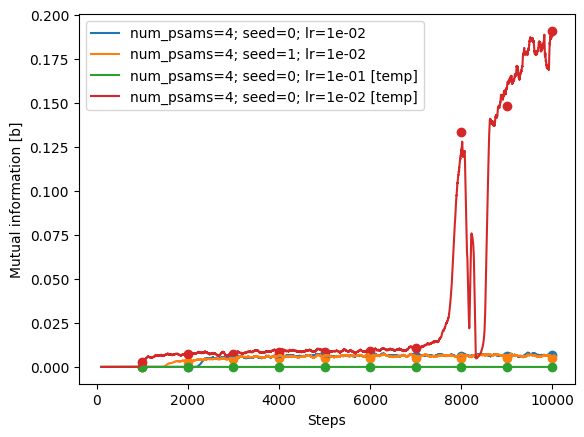

In [8]:
# plot_curve(0, 50)
# plot_curve(1, 50)
plot_curve(0, 4, 1e-2)
plot_curve(1, 4, 1e-2)
plot_curve(0, 4, 1e-1, with_temperature=1)
plot_curve(0, 4, 1e-2, with_temperature=1)
# plot_curve(1, 4, 1e-2, with_temperature=1)
# plot_curve(0, 4, 1e-3, with_temperature=1)
plt.legend()
plt.ylabel("Mutual information [b]")
plt.xlabel("Steps")
plt.show()

Parameter containing:
tensor(-0.0046, requires_grad=True)


array([<Axes: title={'center': '1'}>, <Axes: title={'center': '2'}>,
       <Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>],
      dtype=object)

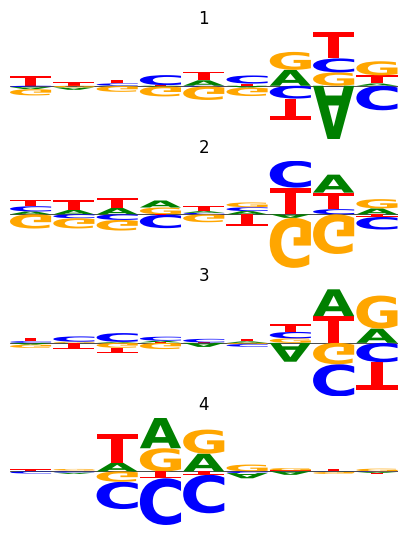

In [9]:
m = train_model(0, 4, 1e-2, with_temperature=1)[0][-1]
print(m.temperature)
m = m.psam_pdfa
p = m.psam
render_psams(
    p.sequence_logos, names=range(1, 1 + len(p.sequence_logos)), psam_mode="raw"
)

0 0.5029654 4@50%
2 0.22170259 4@22%
3 0.21659523 4@22%


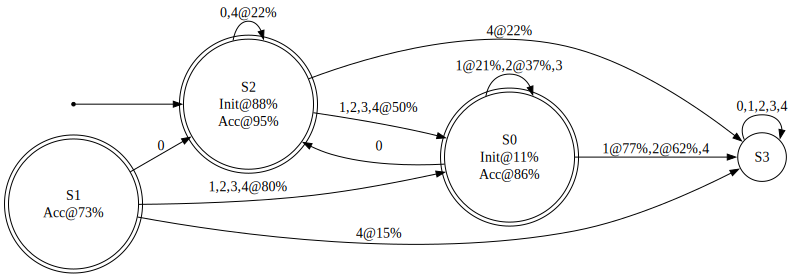

In [10]:
m.pdfa.to_dfa_for_viz(0.1)